# Robust Controlled Trials

The Randomized Controlled Trial (RCT) is a trusted method in experimental design that aims to figure out responses to certain interventions, while reducing the discrepancy in results due to variance in subjects. In fact, in 2019, Prof. Duflo and Banerjee from MIT got the Nobel Prize in Economics for addressing questions/issues in development economics (esp. poverty and availability of healthcare) using RCTs. 

But very few people discuss the fact that RCTs are quite ineffective in one major aspect: They rely on the **Central Limit Theorem** to ensure that control and experiments have similar inter-group and intra-group distributions of traits. This requires large experimental populations, which are expensive and often unavailable. 

Instead, there is research to suggest that **optimal controlled trials** can be significantly more powerful. 

This demo will hopefully demonstrate that randomization is NOT a reliable method for getting the right distribution of "features" in subjects. Furthermore, it will demonstrate the influence of robustness to uncertainty in our subject data on optimal experimental design. 

## Motivational Problem: Medical Trials

Suppose that we only have the budget to conduct initial Covid-19 vaccine trials on 20 patients, where the patients are split 50/50 between control and treatment groups. We have had 25 applicants with 5 traits, generated randomly in this instance. (We have chosen small numbers since this problem can quickly become computationally challenging, but it is definitely solvable in larger scale as well.)

First, we initialize our computational environment.

In [1]:
# Activating Julia environment
using Pkg
Pkg.activate(".")
include("roct.jl")
GUROBI_OPTIMIZER = optimizer_with_attributes(Gurobi.Optimizer, "Threads" => 12, "OutputFlag" => 1)

  Activating project at `C:\Users\BOZTURK\Documents\Code\ROdemos\demos`


MathOptInterface.OptimizerWithAttributes(Gurobi.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("Threads") => 12, MathOptInterface.RawOptimizerAttribute("OutputFlag") => 1])

Then, we generate some random patients, with traits being sampled from the standard normal. 

In [2]:
n_groups = 2                     # number of groups
n_patients = 20                  # total number of patients
n_ppg = Int(n_patients/n_groups) # number of patients per group
n_people = 25                    # total 
n_traits = 5
data = generate_random_people(n_people, n_traits)
target_means = zeros(n_traits) #vec(sum(data[:, :], dims=1)/n_people) 
target_variances = ones(n_traits) #vec(sum(data[:, :].^2, dims=1)/n_people);
DataFrames.show(DataFrame(data, :auto))

25×5 DataFrame
 Row │ x1           x2          x3         x4          x5          
     │ Float64      Float64     Float64    Float64     Float64     
─────┼─────────────────────────────────────────────────────────────
   1 │  0.774654     2.31815    -0.84185   -0.0957358   1.32636
   2 │ -1.01582      0.865053   -0.724184  -0.887943    0.753483
   3 │  0.516427     0.563967    1.59025   -2.08313    -0.938125
   4 │ -1.05028     -0.371572    0.297168  -0.927629   -0.323323
   5 │  2.05647      0.984907    0.106989  -1.20333    -0.388977
   6 │ -1.9353       0.367522    1.44876   -1.2352     -0.108608
   7 │ -0.633568     0.724233    0.138301   0.429393   -0.626592
   8 │  1.25372      0.212117   -0.444048  -0.0748496   1.35658
   9 │  1.34965      0.490984    1.48918   -1.00069     1.03556
  10 │ -0.00830964   1.13608     1.08191   -0.662006   -1.13805
  11 │ -1.38975      0.993574    1.17       0.306575   -1.27035
  ⋮  │      ⋮           ⋮           ⋮          ⋮            ⋮
  16 │ -1

Initially, we will create our control and experiment groups by simply picking the first 10 to be in the control, and the next 10 to be in the experiment groups. Then, we can evaluate the means and variances of the traits of patients in each group, and compare them. 
(For simplicity, we will only consider the diagonal of the covariance matrix. However, this method can be extended to the full covariance matrix, by adding a lot more variables!)

In [3]:
# Experimental design through randomization
ctrl_idxs = Int64.(collect(1:n_patients/2))
vacc_idxs = Int64.(collect(n_patients/2+1:n_patients))
print_details(data, ctrl_idxs, vacc_idxs)

Control group: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Vaccine group: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Mean traits of control group: [0.1308 0.7291 0.4142 -0.7741 0.09483]
Mean traits of vaccine group: [-0.6212 -0.00629 0.1871 0.3829 0.001396]
Var of traits of control group: [1.46 0.4468 0.7849 0.4608 0.7985]
Var of traits of vaccine group: [0.3104 0.386 0.7663 0.7546 0.4158]
Nominal objective: 4.714


We will describe the objective function in greater detail later, but we can think about it as some sum of errors between the means and variances of the experiment and control groups. 

We can examine these errors more specifically by plotting them.

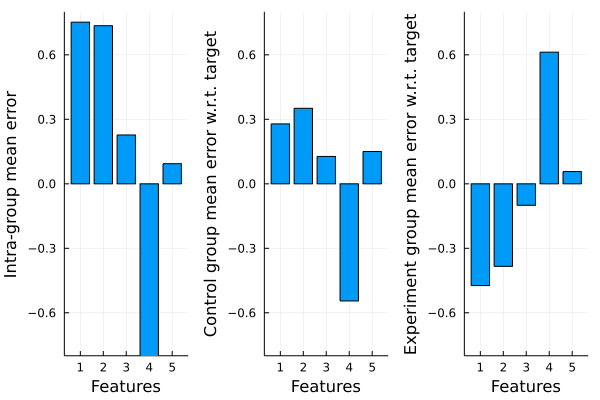

In [4]:
plot_errors(data, ctrl_idxs, vacc_idxs)

Clearly, there are some discrepancies between the means and variances of the groups.

### Can Optimization do better? 
It sure can! In this case, we will pick 2 groups of equal numbers of patients from the population, while minimizing some notion of error between the moments of traits in the two populations. 

To begin, we are going to define some target means $\bar{\mu}_j$ and variances $\bar{\sigma}_j$. For this toy example, we are going to assume that our target mean is the whole population mean, and the target variance is the whole population variance. (In theory, we can aim to achieve any target mean and variance we would like, for any number of groups.)

Then we are going to define new variables $M_j$ and $V_j$, where $j$ is the trait index. These will define the maximum of inter-population and intra-group mean and variance errors as follows. 

$M_j = \rm{max}\Big(|\mu_{j,1} - \mu_{j,2}|, |\mu_{j,1} - \bar{\mu}_j|, |\mu_{j,2} - \bar{\mu}_j||\Big),$

$V_j = \rm{max}\Big(|\sigma_{j,1} - \sigma_{j,2}|, |\sigma_{j,1} - \bar{\sigma}_j|, |\sigma_{j,2} - \bar{\sigma}_j||\Big).$

The **intra-group** error is the differences in the statistics of the experiment and control groups. The **inter-population** error is the difference between the statistics of each group and the target distributions. 

Our objective function will be a mixture of these two errors:

Objective function $= \sum M_j + 0.5\sum V_j$

Note that we are not limited to this objective function. (For example, we could try minimizing variance while keeping the mean variation below a threshold... we can try any combination that is bounded!)

This way, the groups will look like each other and like the entire population as much as possible. Let's actually solve this representation of the problem. 

In [5]:
# Let's start creating out model, and trying to solve without uncertainty
model = optimized_trial_model(data, n_groups, n_ppg, 
    target_means = target_means, target_variances = target_variances, 
    regularizer = 0.5, optimizer = GUROBI_OPTIMIZER)

A JuMP Model
Minimization problem with:
Variables: 81
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 22 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 60 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 25 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 50 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: M, V, d, x, μ_p, σ_p

In [6]:
optimize!(model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 16 physical cores, 16 logical processors, using up to 8 threads
Optimize a model with 107 rows, 81 columns and 760 nonzeros
Model fingerprint: 0xe7c3f115
Variable types: 31 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4.3060913
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 107 rows, 80 columns, 752 nonzeros
Variable types: 30 continuous, 50 integer (50 binary)

Root relaxation: objective 7.712427e-01, 132 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.77124    0   23    4.30609    0.77124  82.1%     -    0s
H    0     0                       1.9948787    0.77124  61.

Let's see the results, and how our patients (by index) have changed compared to randomization.

In [7]:
# Results
(ctrl_opt, vacc_opt) = group_subjects(model, 2)
print_details(data, ctrl_opt, vacc_opt)

Control group: [2, 5, 9, 12, 13, 18, 20, 22, 23, 25]
Vaccine group: [1, 3, 7, 8, 11, 15, 16, 19, 21, 24]
Mean traits of control group: [-0.02677 0.3089 0.1397 -0.05857 -0.01488]
Mean traits of vaccine group: [-0.01968 0.3891 0.1185 -0.0824 -0.003718]
Var of traits of control group: [0.9944 0.9055 0.9714 0.8199 1.131]
Var of traits of vaccine group: [0.8842 0.8111 0.7011 0.7463 0.8639]
Nominal objective: 1.215


We see a massive improvement in the objective function! We can also see the reduction in mean and variance errors graphically. 

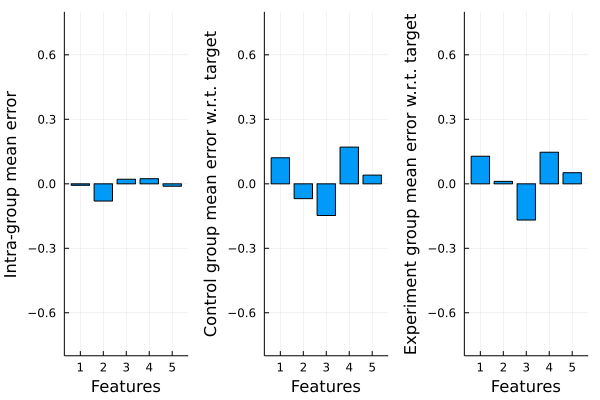

In [8]:
# Plotting the distribution of errors
plot_errors(data, ctrl_opt, vacc_opt)

What this means is that optimization dramatically improves on the quality of the experiment and control groups generated via randomization. It can thus improve the ability of experiments to have significant results, and can allow us to reduce the number of subjects we require to obtain that significance. 

### How does Robust Optimization (RO) change our solutions? 
It is very possible that there is some error in the values of the traits of each subject. These errors could arise from a variety of sources: measurement error, observer's paradox, or even due to subjects lying in order to influence their perceived likelihood of being in the treatment group!

We will deal with this kind of uncertainty through **robust OCTs**. Robust OCT will assume that there is uncertainty in the data in the problem that is defined by an uncertainty set. One potential description of the uncertainty is a **budget uncertainty set**, where the maximum absolute deviation of each trait for each subject is constrained ($||\mathbf{z}||_{\infty} \leq \rho$), as well as the cumulative absolute deviations of each trait for all subjects ($||\mathbf{z}||_{1} \leq \Gamma$). In this case, we assume such an uncertainty set, with an maximum absolute deviation $\rho = 1$, and a cumulative deviation $\Gamma = 5$. Intuitively, this would allow up to 5 trait perturbations of magnitude 1, 10 trait perturbations of magnitude 0.5, or 20 perturbations of magnitude 0.25, and so on. 

In [9]:
robust_model = robust_optimized_trial_model(data, n_groups, n_ppg,
    target_means = target_means, target_variances = target_variances, 
    ρ = 1, Γ = 5, regularizer = 0.5, optimizer = GUROBI_OPTIMIZER)

A JuMP Model
Minimization problem with:
Variables: 3140
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 22 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 6060 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 25 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 50 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi
Names registered in the model: M, V, x, μ_p, σ_p

*A math aside:* There is some complex robust optimization modeling behind the scenes here, due to the definition of the means and variances as *equalities*. Since adding robustness directly to linear equalities makes the optimization problem infeasible, we cannot directly embed the uncertainty into the constraints describing means $\mu$ and variances $\sigma$. Instead, we embed the uncertainty minimize the set into the model through the robust counterpart of the errors $\mathbf{M}$ and $\mathbf{V}$, and minimize their worst-case errors!

In [10]:
set_start_value.(robust_model[:x], value.(model[:x]));
optimize!(robust_model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 16 physical cores, 16 logical processors, using up to 8 threads
Optimize a model with 6107 rows, 3140 columns and 20240 nonzeros
Model fingerprint: 0xab5997aa
Variable types: 3090 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [5e-06, 1e+01]
  Objective range  [5e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]

User MIP start produced solution with objective 7.33485 (0.11s)
Loaded user MIP start with objective 7.33485

Presolve removed 20 rows and 20 columns
Presolve time: 0.08s
Presolved: 6087 rows, 3120 columns, 19656 nonzeros
Variable types: 3070 continuous, 50 integer (50 binary)

Root relaxation: objective 3.782477e+00, 4806 iterations, 0.48 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.78248    0   48    7.33485    3.782

It seems like we have found a design of experiments that is robust to the budget uncertainty set! Let's take a look at the results.

In [11]:
println("Robust optimal results:")
ctrl_ro, vacc_ro = group_subjects(robust_model, 2)
print_details(data, ctrl_ro, vacc_ro)
println("Robust worst-case objective: ", objective_value(robust_model))

Robust optimal results:
Control group: [5, 7, 10, 12, 13, 14, 16, 17, 19, 21]
Vaccine group: [2, 4, 8, 11, 15, 18, 20, 22, 24, 25]
Mean traits of control group: [-0.207 0.3666 0.2144 -0.06069 -0.005144]
Mean traits of vaccine group: [-0.2417 0.3039 0.07221 -0.04536 0.01124]
Var of traits of control group: [0.8393 0.4952 0.7215 0.6831 0.4219]
Var of traits of vaccine group: [0.7838 0.8092 0.7218 0.6662 0.66]
Nominal objective: 1.855
Robust worst-case objective: 7.071936227307412


We observe slight changes in the optimal allocations of patients. Obviously, the nominal objective is strictly worsened under robustness considerations. However, in presence of uncertainty, this new experimental design makes sure that the worst case outcome of our objective function will be much less adverse than the nominal case. The OED without robustness can be a lot more sensitive to this uncertainty. Below, we compare the allocations of patients and their statistics for all three cases, in addition to computing the worst-case outcomes for comparison. 

In [12]:
println("Robust-optimal results:")
print_details(data, ctrl_ro, vacc_ro)
ro_worst = compute_worst_case(robust_model, ctrl_ro, vacc_ro)
println("Worst-case objective: ", ro_worst)
println("")
println("Deterministic-optimal results:")
print_details(data, ctrl_opt, vacc_opt)
opt_worst = compute_worst_case(robust_model, ctrl_opt, vacc_opt)
println("Worst-case objective: ", opt_worst)
println("")
println("Random selection result:")
print_details(data, ctrl_idxs, vacc_idxs)
nom_worst = compute_worst_case(robust_model, ctrl_idxs, vacc_idxs)
println("Worst-case objective: ", nom_worst)

Robust-optimal results:
Control group: [5, 7, 10, 12, 13, 14, 16, 17, 19, 21]
Vaccine group: [2, 4, 8, 11, 15, 18, 20, 22, 24, 25]
Mean traits of control group: [-0.207 0.3666 0.2144 -0.06069 -0.005144]
Mean traits of vaccine group: [-0.2417 0.3039 0.07221 -0.04536 0.01124]
Var of traits of control group: [0.8393 0.4952 0.7215 0.6831 0.4219]
Var of traits of vaccine group: [0.7838 0.8092 0.7218 0.6662 0.66]
Nominal objective: 1.855
Worst-case objective: 7.071936227307412

Deterministic-optimal results:
Control group: [2, 5, 9, 12, 13, 18, 20, 22, 23, 25]
Vaccine group: [1, 3, 7, 8, 11, 15, 16, 19, 21, 24]
Mean traits of control group: [-0.02677 0.3089 0.1397 -0.05857 -0.01488]
Mean traits of vaccine group: [-0.01968 0.3891 0.1185 -0.0824 -0.003718]
Var of traits of control group: [0.9944 0.9055 0.9714 0.8199 1.131]
Var of traits of vaccine group: [0.8842 0.8111 0.7011 0.7463 0.8639]
Nominal objective: 1.215
Worst-case objective: 7.334850532544223

Random selection result:
Control group

What we see is that the robust optimal solution definitively has the lowest worst-case objective, and while the optimal solution (without uncertainty) has a better nominal outcome, it is somewhat more sensitive to uncertainties in the traits of the subjects. The randomized cases is again by far the worst, having the worst performance both without and with uncertainty. 

For curiosity's sake, we also plot the mean and variance errors for the robust solution. 

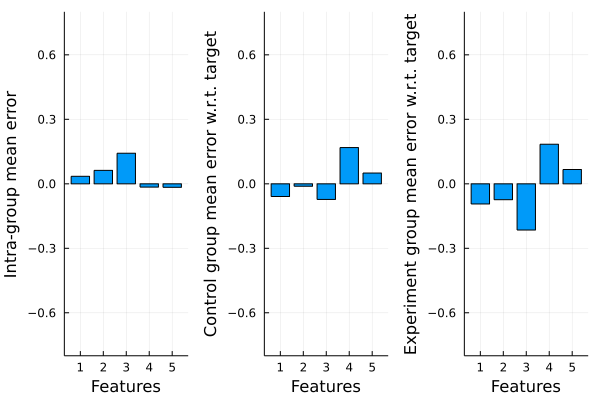

In [13]:
plot_errors(data, ctrl_ro, vacc_ro)

# Future work

This kind of experimental design can be dramatically improved by: 
- Adding consideration for categorical variables,
- Considering different types of uncertainty in the features. (Currently we only consider column-wise budget uncertainty.)
- Constructing uncertainty sets directly from uncertainty in data, and 
- Adding the ability to simulate group performance under different uncertain outcomes. 

# Conclusions

- Optimization of trials is a useful method to make sure that the moments of the features our experiment and control groups are similar, while adhering to a target distribution of features. 
- Uncertainty can result from a variety of factors in experimental designs. 
- Robust OCTs can improve the efficacy of experiments with small reduction in nominal performance compared to optimized groups without uncertainty. However, robust OCT gives significantly better worst-case outcomes, and reduces the sensitivity of experiments to uncertainty in the traits of control and experiment subjects!
- Randomization is consistently the **worst** method for experimental design by far!